In [254]:
import numpy as np
import matplotlib.pyplot as plt

## コーパスの前処理

In [230]:
text = 'You say goobye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
print(text)

words = text.split(sep=' ')
print('split後:', words)

you say goobye and i say hello .
split後: ['you', 'say', 'goobye', 'and', 'i', 'say', 'hello', '.']


In [231]:
# 単語のid化

# 対応するdictを作成
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goobye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [232]:
# 数値として扱いやすいようにwordsを単語idに変換
corpus = [word_to_id[word] for word in words]

# np.array
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [233]:
# 上記の処理を関数化

def preprocess(texts):
    texts = texts.lower()
    texts = texts.replace('.', ' .')
    words = texts.split(sep=' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [234]:
# 関数チェック
text = 'You say goobye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

・コーパスを扱う準備はこれで終わり。  
・次からはこのコーパスを使用して、単語の意味を抽出をする。　-> 「カウントベースの手法」  
・単語の意味を的確に捉えたベクトル表現を目指す。 (ex: 色のRGBのようなベクトル表現  ->  分散表現  
・単語の分散表現：単語を固定長のベクトルで表現、密なベクトル。  
<br>
・単語の意味は周囲の単語によって形成される

## 共起行列

In [235]:
# テキストと前処理
text = 'You say goobye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goobye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [236]:
# 共起行列 (window size = 1)


C = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0]
], dtype=np.int32)

In [237]:
# コーパスから共起行列を作る関数

def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros([vocab_size, vocab_size], dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [238]:
# コサイン類似度
def cos_similarity(x, y, eps=1e-8):
    nx = x/(np.sqrt(np.sum(x**2))+eps)
    ny = y/(np.sqrt(np.sum(y**2))+eps)
    return np.dot(nx, ny)    

In [239]:
# コサイン類似度のチェック
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

# youとIの類似度
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(c0)
print(c1)
print(cos_similarity(c0, c1))





[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799


In [240]:
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

# 類似単語のランキング表示

In [241]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # クエリを取り出す
    if query not in word_to_id:
        print(f'{query}is not found')
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # コサイン類似度の算出
    vaocab_size = len(word_to_id)

    # word_matrix毎の類似度を出して、similarityに保管 -> similarityはword_matrix, id_to_word, word_to_idのインデックスに対応
    similarity = np.zeros(vaocab_size)
    for i in range(vaocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # ランキング
    count=0
    # argsortは昇順に並び替えた時の元値のインデックスを返す
    # 昇順なので−１をかけている -> コサイン類似度は1に近いほど類似している
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f'{id_to_word[i]}: {similarity[i]}')

        count += 1

        if count >= top:
            return

In [242]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C)


[query] you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


## 相互情報量

In [243]:
def ppmi (C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32) # 変換後の入れ物
    N = np.sum(C) # Xコーパス内の単語数 -> 共起行列の総数
    S = np.sum(C, axis=0) # 共起行列における各単語の出現数
    total = C.shape[0] * C.shape[1] # 共起行列の要素数
    cnt=0
    count=0
    
    # 共起行列の各要素におけるpmiを算出 -> 該当要素と同じ場所のMに格納
    for i in range(C.shape[0]):
        count+=1
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) # epsは-infを避けるため
            M[i, j] = max(0,pmi) # -inf近くの値を避けるため,0以上の値にする

            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print('{:.1f}% done'.format(100*cnt/total))

    return M

In [244]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C) 

np.set_printoptions(precision=3) # 下3桁表示
print('vocablary')
print(list(word_to_id.keys()))
print('='*50)

print('co-occurence matrix')
print(C)

print('='*50)
print('PPMI')
print(W)

vocablary
['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']
co-occurence matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


＜問題点＞  
・コーパスの語彙が増えると、ベクトルの次元も増えていく問題がある。  
・疎行列 -> ロバスト性が乏しく、ノイズに弱い

## 次元削減

In [263]:
# 今回使用するのは特異値分解(SVD)


text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C) 

# SVD
U, S, V = np.linalg.svd(W)

print(C[0])
print(W[0])
print(U[0])


[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -1.110e-16 -9.323e-01
 -2.426e-17]


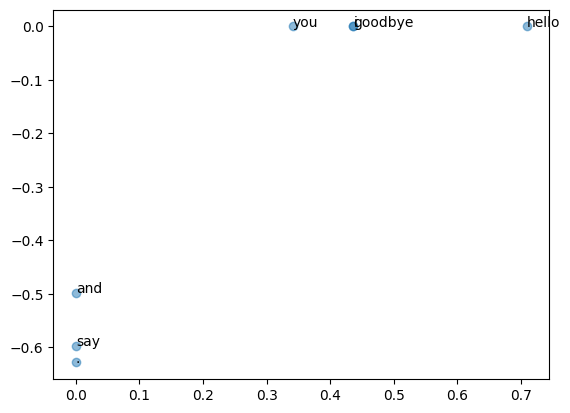

In [282]:

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 1], U[word_id, 0]))

plt.scatter(U[:, 1], U[:, 0], alpha=0.5)

In [276]:
U[:, 0:2]

array([[ 0.000e+00,  3.409e-01],
       [-5.976e-01,  0.000e+00],
       [-5.551e-17,  4.363e-01],
       [-4.978e-01,  1.665e-16],
       [-3.124e-17,  4.363e-01],
       [-3.124e-17,  7.092e-01],
       [-6.285e-01, -1.943e-16]], dtype=float32)

## PTBデータセットk

In [284]:
from hidden_others.dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

Done


In [287]:
print('corpus size:', len(corpus))
print('corpus[:30]', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print('word_to_id[car]', word_to_id['car'])
print('word_to_id[happy]', word_to_id['happy'])
print('word_to_id[lexus]', word_to_id['lexus'])




corpus size: 929589
corpus[:30] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id[car] 3856
word_to_id[happy] 4428
word_to_id[lexus] 7426


In [289]:
from common.util import most_similar, create_co_matrix, ppmi
window_size = 2
wordvec_size = 100


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurrence....')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI....')
W = ppmi(C, verbose=True)

print('calculating SVD...')
try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)


word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting co-occurrence....
calculating PPMI....
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0